In [36]:
import os
import re
import json
import codecs
import locale
import requests
import datetime

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from typing import Any, Tuple, Dict

import pandas as pd
locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

'it_IT.UTF-8'

In [37]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------
data_file_path = os.path.join("..","data")
images_path = os.path.join("..","images")
image_prefix = ""

csv_data_file = os.path.join(data_file_path, "italy-regions.csv")

now = datetime.datetime.now()
today_day_name = now.strftime("%A")

date_format = '%d/%m/%Y'


In [38]:
df = pd.read_csv(csv_data_file, sep=',')
df["TimeStamp"] = pd.to_datetime(df["REPORT DATE"], format="%Y/%m/%d")

last_sample = df["TimeStamp"].max().strftime(date_format)

(df.shape, "Min date:", df["TimeStamp"].min(), "Max date:", df["TimeStamp"].max(), df.columns)

((2604, 17),
 'Min date:',
 Timestamp('2020-06-25 00:00:00'),
 'Max date:',
 Timestamp('2020-10-27 00:00:00'),
 Index(['Regione', 'Ricoverati con sintomi', 'Terapia intensiva',
        'Isolamento domiciliare', 'Totale attualmente positivi',
        'DIMESSI/GUARITI', 'DECEDUTI', 'CASI TOTALI - A',
        'INCREMENTO CASI TOTALI (rispetto al giorno precedente)',
        'Casi identificatidal sospettodiagnostico',
        'Casi identificatida attività discreening', 'CASI TOTALI - B',
        'Totale casi testati', 'Totale tamponi effettuati', 'INCREMENTOTAMPONI',
        'REPORT DATE', 'TimeStamp'],
       dtype='object'))

In [39]:
df.head(5)

,Regione,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale attualmente positivi,DIMESSI/GUARITI,DECEDUTI,CASI TOTALI - A,INCREMENTO CASI TOTALI (rispetto al giorno precedente),Casi identificatidal sospettodiagnostico,Casi identificatida attività discreening,CASI TOTALI - B,Totale casi testati,Totale tamponi effettuati,INCREMENTOTAMPONI,REPORT DATE,TimeStamp
0,Lombardia,1521,134,28235,29890,87591,17123,134604,4125,113622,20982,134604,1611623,2575003,36416,2020-10-21,2020-10-21
1,Piemonte,1111,74,12250,13435,30467,4216,48118,1799,26093,22025,48118,529281,895399,13611,2020-10-21,2020-10-21
2,Emilia-Romagna,596,86,10118,10800,27257,4531,42588,671,34999,7589,42588,777142,1417038,17165,2020-10-21,2020-10-21
3,Veneto,439,56,10938,11433,24550,2282,38265,1422,23338,14927,38265,849385,2178114,19627,2020-10-21,2020-10-21
4,Campania,996,85,20020,21101,8838,545,30484,1760,28264,2220,30484,548083,802965,13878,2020-10-21,2020-10-21


In [40]:
# Grouping by week.
def weekly_gouping_total_infected(region_name:str, df:pd.DataFrame) -> Tuple[bool, Any]:
    rv = False
    result = None
    print("weekly_gouping_total_infected ({reg}) >>".format(reg=region_name))
    try:
        df_region = df.loc[df["Regione"] == region_name]
        df_group_ti = df_region.groupby(pd.Grouper(key='TimeStamp', freq='W'))['Totale attualmente positivi'].agg('sum')
        
        df_group_ti = df_group_ti.to_frame()
        df_group_ti.reset_index(level=0, inplace=True)
        df_group_ti["Delta"] = df_group_ti["Totale attualmente positivi"].diff(periods = 1)

        result = df_group_ti
        rv = True
    except Exception as ex:
        print("Exception - {e}".format(e=ex))
        result = ex
    print("weekly_gouping_total_infected ({rv}) >>".format(rv=rv))
    return (rv, result)

def weekly_gouping_intensive_care(region_name:str, df:pd.DataFrame) -> Tuple[bool, Any]:
    rv = False
    result = None
    print("weekly_gouping_intensive_care ({reg}) >>".format(reg=region_name))
    try:
        df_region = df.loc[df["Regione"] == region_name]
        df_group = df_region.groupby(pd.Grouper(key='TimeStamp', freq='W'))['Terapia intensiva'].agg('sum')
        
        df_group = df_group.to_frame()
        df_group.reset_index(level=0, inplace=True)
        df_group["Delta"] = df_group["Terapia intensiva"].diff(periods = 1)

        result = df_group
        rv = True
    except Exception as ex:
        print("Exception - {e}".format(e=ex))
        result = ex
        
    #df_group.head(10)
    print("weekly_gouping_intensive_care ({rv}) <<".format(rv=rv))
    return (rv, result)

In [41]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0, fontsize=8):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom'
               ,fontsize=fontsize)
        
def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv  

In [42]:
def total_and_diff_chart(ax, df:pd.DataFrame, chart_configurations: Dict[str, str]) -> Tuple[bool, Any]:
    """
    
    """
    rv = False
    result = None
    try:
        idx = 0
        width = 0.8

        x_weeks = df['TimeStamp']
        x_weeks_lbl = df['TimeStamp'].dt.strftime('%Y-%m-%d')
        #y_values = df['Totale attualmente positivi']
        #y_delta = df['Delta']

        y_values = df[chart_configurations['Value']]
        y_delta = df[chart_configurations['Delta']]

        set_axes_common_properties(ax[0], no_grid=False)

        rects = ax[idx].bar(x_weeks_lbl, y_values, color="#dcd9d8", width=width, label='Regione {reg}'.format(reg=region_name))
        ax[idx].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
        ax[idx].xaxis.set_minor_formatter(mdates.DateFormatter("%d/%m"))
        ax[idx].set_ylabel(chart_configurations['yLabel'], fontsize=14)
        ax[idx].set_xlabel(chart_configurations['xLabel'], fontsize=14)

        ax[idx].set_title("{reg} - {title} ({dt})".format(title=chart_configurations['Title'],dt=last_sample, reg=region_name, fontsize=18))
        ax[idx].tick_params(axis='both', labelsize=14)
        ax[idx].set_xticklabels(x_weeks_lbl, rotation=80)

        autolabel(rects, ax[idx], dec_no=1, fontsize=12)
        
        format_y_label_thousands(ax[idx])

        ax_diff = ax[idx].twinx()
        set_axes_common_properties(ax_diff, no_grid=True)
        remove_tick_lines('y', ax_diff)
        remove_tick_lines('x', ax_diff)
        ax_diff.set_ylabel(chart_configurations['yLabelAlt'], fontsize=14)
        ax_diff.yaxis.label.set_color("#df700d")
        ax_diff.tick_params(axis='y', colors="#df700d")
       
        ax_diff.scatter(x_weeks_lbl, y_delta, color="#f09352", s=150, marker=".", label="")
        ax_diff.plot(x_weeks_lbl, y_delta, 'b-', linewidth=2, color="#f09352")

        format_y_label_thousands(ax_diff)
        
    except Exception as ex:
        print("Exception - {ex}".format(ex=ex))
        rv = False
        result = None
    return (rv, result)

def format_y_label_thousands(ax): # format y-axis tick labels formats
    ax = plt.gca()
    label_format = '{:,.0f}'
    ax.set_yticks(ax.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    ax.set_yticklabels([label_format.format(x) for x in ax.get_yticks().tolist()])


weekly_gouping_total_infected (Lombardia) >>
weekly_gouping_total_infected (True) >>
Tipo: <class 'pandas.core.frame.DataFrame'>


<ipython-input-42-ff478652cc63>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x_weeks_lbl, rotation=80)


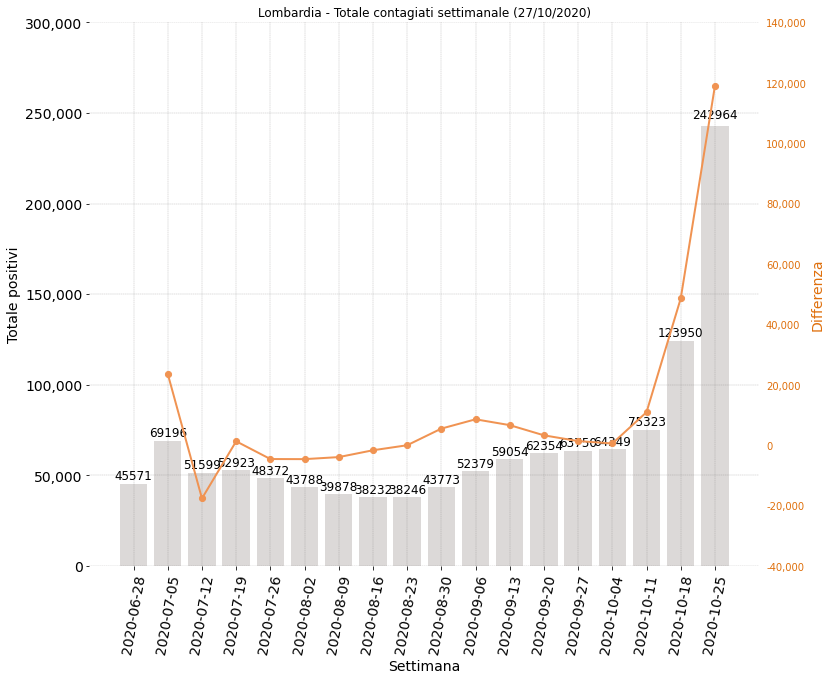

In [43]:
#-------------------------------------------------
#
#-------------------------------------------------

regions_list = [
    "Lombardia"
    ,"Campania"
    ,"Liguria"
    ,"Piemonte"
    ,"Veneto"
]

region_name = regions_list[0]

#-------------------------------------------------
# Manage the data to be charted.
#-------------------------------------------------
rv, df_week_ti = weekly_gouping_total_infected(region_name, df)
assert rv, "Unable to group by region ({reg}).".format(reg=region_name)

print("Tipo: {t}".format(t=type(df_week_ti)))

# Remove the last week if incomplete.
if today_day_name != 'domenica':
    df_week_ti = df_week_ti[:-1]

#-------------------------------------------------
# Chart configuration and build.
#-------------------------------------------------
fig = plt.figure(figsize=(12, 10))
gs1 = gridspec.GridSpec(1, 1
                       ,hspace=0.2
                       ,wspace=0.1 
                       ,figure=fig)

ax = []
ax.append(fig.add_subplot(gs1[0,0]))

chart_configurations = {
    'Value': 'Totale attualmente positivi'
    ,'Delta': 'Delta'
    ,'yLabel': 'Totale positivi'
    ,'yLabelAlt': 'Differenza'
    ,'xLabel': 'Settimana'
    ,'Title': 'Totale contagiati settimanale'
}
rv = total_and_diff_chart(ax, df_week_ti, chart_configurations)
assert rv, "ERROR - cannot create the chart."

plt.savefig(os.path.join(images_path,"{prefix}RegionWeekly-TotalInfected-{reg}.png".format(reg=region_name, prefix=image_prefix))
           ,bbox_inches = 'tight'
           ,facecolor='white'
           ,pad_inches = 0.2)
    

In [44]:
df_week_ti

,TimeStamp,Totale attualmente positivi,Delta
0,2020-06-28,45571,NaN
1,2020-07-05,69196,23625.0
2,2020-07-12,51599,-17597.0
3,2020-07-19,52923,1324.0
4,2020-07-26,48372,-4551.0
5,2020-08-02,43788,-4584.0
6,2020-08-09,39878,-3910.0
7,2020-08-16,38232,-1646.0
8,2020-08-23,38246,14.0
9,2020-08-30,43773,5527.0


weekly_gouping_intensive_care (Lombardia) >>
weekly_gouping_intensive_care (True) <<
Tipo: <class 'pandas.core.frame.DataFrame'>


<ipython-input-42-ff478652cc63>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x_weeks_lbl, rotation=80)


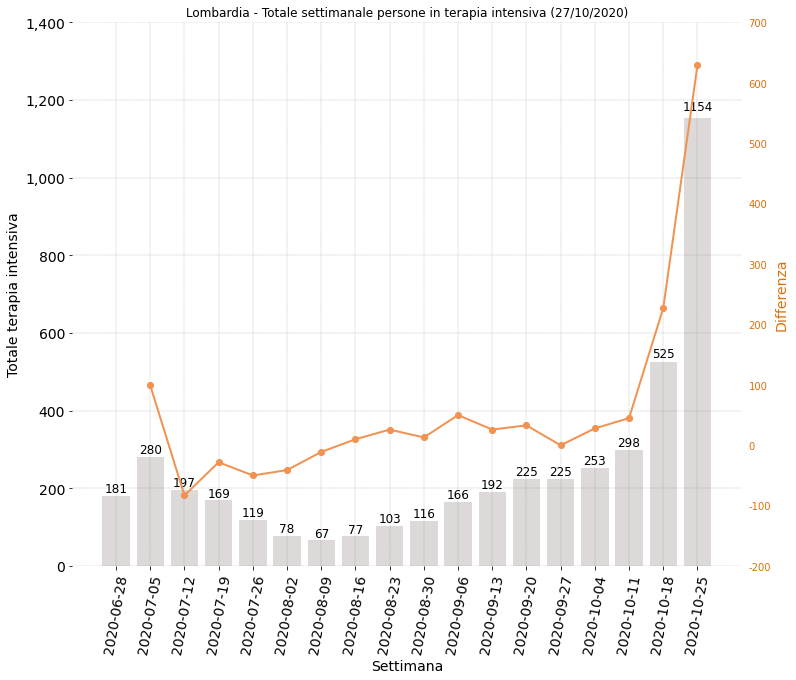

In [45]:
#-------------------------------------------------
# Manage the data to be charted.
#-------------------------------------------------
rv, df_week_ic = weekly_gouping_intensive_care(region_name, df)
assert rv, "Unable to group by region ({reg}).".format(reg=region_name)
print("Tipo: {t}".format(t=type(df_week_ic)))

# Remove the last week if incomplete.
if today_day_name != 'domenica':
    df_week_ic = df_week_ic[:-1]

#-------------------------------------------------
# Chart configuration and build.
#-------------------------------------------------
fig = plt.figure(figsize=(12, 10))
gs1 = gridspec.GridSpec(1, 1
                       ,hspace=0.2
                       ,wspace=0.1 
                       ,figure=fig)

ax = []
ax.append(fig.add_subplot(gs1[0,0]))

chart_configurations = {
     'Value': 'Terapia intensiva'
    ,'Delta': 'Delta'
    ,'yLabel': 'Totale terapia intensiva'
    ,'yLabelAlt': 'Differenza'
    ,'xLabel': 'Settimana'
    ,'Title': 'Totale settimanale persone in terapia intensiva'
}
rv = total_and_diff_chart(ax, df_week_ic, chart_configurations)
assert rv, "Error - cannot create the chart."
    
plt.savefig(os.path.join(images_path,"{prefix}RegionWeekly-IntensiveCare-{reg}.png".format(reg=region_name, prefix=image_prefix))
           ,bbox_inches = 'tight'
           ,facecolor='white'
           ,pad_inches = 0.2)
    


In [46]:
df_week_ic

,TimeStamp,Terapia intensiva,Delta
0,2020-06-28,181,NaN
1,2020-07-05,280,99.0
2,2020-07-12,197,-83.0
3,2020-07-19,169,-28.0
4,2020-07-26,119,-50.0
5,2020-08-02,78,-41.0
6,2020-08-09,67,-11.0
7,2020-08-16,77,10.0
8,2020-08-23,103,26.0
9,2020-08-30,116,13.0


In [47]:
df_week_ic

,TimeStamp,Terapia intensiva,Delta
0,2020-06-28,181,NaN
1,2020-07-05,280,99.0
2,2020-07-12,197,-83.0
3,2020-07-19,169,-28.0
4,2020-07-26,119,-50.0
5,2020-08-02,78,-41.0
6,2020-08-09,67,-11.0
7,2020-08-16,77,10.0
8,2020-08-23,103,26.0
9,2020-08-30,116,13.0
